In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import ScalarFormatter, NullFormatter

plt.rcParams.update({'font.size': 14})
matplotlib.rcParams['xtick.minor.size'] = 0
matplotlib.rcParams['xtick.minor.width'] = 0

import sys
sys.path.append("..")

from ContrastEstimation import util, IntensityEstimation, ContrastEstimation, MoleculeZoo

# Define the Incident Beam

In [2]:
expParams = {}

# Photon energy and bandwidth
expParams['photon_energy_keV'] = 9.5  # Beam central photon energy in keV
expParams['bandwidth_keV'] = 0.4 * 1e-3 # Beam bandwidth in keV

# Beam size (focusing spot size)
expParams['beam_size_out_plane'] = 2  # (um) Beam size on the sample perpendicular to the diffraction plane
expParams['beam_size_in_plane'] = 2  # (um) Beam size on the sample within the diffraction plane

# Beam transverse coherence length (No need to change for LCLS beams)
expParams['trans_coh_length_out_plane'] = 30.  # (um) Beam coherence length perpendicular to the diffraction plane
expParams['trans_coh_length_in_plane'] = 30.  # (um) Beam coherence length within to the diffraction plane

# Detector pixel parameter
expParams['pixel_size'] = 50.0  # (um) detector pixel size

# Q value of interests
expParams['Q'] = 2. # 2 pi / length scale  # The unit is A^-1

# Scattering Geometry: Gamma = 0 means forward scattering, 1 for back scattering.
# Back scattering is only possible with crystal
expParams['gamma'] = 0.0

##########################################################
#                Parameters to scan.
##########################################################
expParams['sample_thickness'] = 50.  # (um) Sample thickness
expParams['detector_distance'] = 2.0  # (m) Detector distance

# Automatically calculate other quantities to facilicate the calculation
expParams = util.auto_update_expParams(expParams)

# Get the speckle contrast map

In [3]:
num = 100
holder = np.zeros((num, num, 5))

# thickness
thickness_list = np.logspace(1, 4, num)

# detector distances
distance_list = np.logspace(0, 1, num)

# Loop through all conditions
for idx1 in range(num):
    for idx2 in range(num):
        expParams['sample_thickness'] = thickness_list[idx1]
        expParams['detector_distance'] = distance_list[idx2]
        holder[idx1, idx2, :] = ContrastEstimation.get_contrast(expParams)
        
beta_map = holder[:,:,-1]

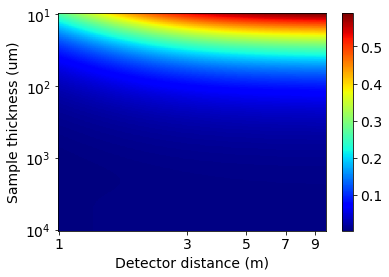

In [4]:
fig, axis = plt.subplots(ncols=1, nrows=1)

img1 = axis.imshow(beta_map,
                   aspect='auto',
                   cmap='jet')
axis.set_xlabel("Detector distance (m)")
axis.set_ylabel("Sample thickness (um)")

axis.set_xticks([100 * np.log10(2 * x + 1) for x in range(5)])
axis.set_xticklabels(["{}".format(2 * x + 1) for x in range(5)])
axis.set_yticks([33 * x for x in range(4)])
axis.set_yticklabels(["$10^{}$".format(x + 1) for x in range(5)])

fig.colorbar(img1, ax=axis)

plt.show()

# Get detector pixel number

In [5]:
pixel_num_holder = np.zeros(100)  # calculate the number of pixels within the range
for i,l in enumerate(distance_list):    
    q_map = ContrastEstimation.get_detector_q_map(theta0 = np.arcsin(expParams['Q'] /2. / expParams['incident_wavevec']),
                               n_pix = 1500,
                               pix_size = expParams['pixel_size'] / 1e6,
                               det_dist = l,
                               incident_wavevec_A = expParams['incident_wavevec'])
    pixel_num_holder[i] = ContrastEstimation.get_pixel_num_in_Q(q_map,
                                                  Q_min = expParams['Q'] * 0.99,
                                                  Q_max = expParams['Q'] * 1.01)

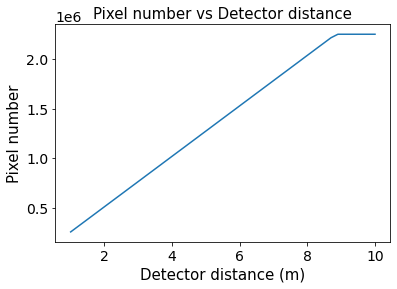

In [6]:
plt.plot(distance_list, pixel_num_holder)
plt.xlabel("Detector distance (m)", fontsize=15)
plt.ylabel("Pixel number", fontsize=15)
plt.title("Pixel number vs Detector distance", fontsize=15)
plt.show()

# Load Water Scattering Data

In [7]:
# Load the WAXS data
H2O_runs = [233,235,236,237,238,239,240,241,242,243,245,246,247]
H2O_temp = [ 30, 50, 75,100,125,150,175,200,225,250,300,325,350]

data_holder = []
for x in range(len(H2O_runs)):
    data_holder.append(np.loadtxt("C:/Users/haoyuan/Desktop/PosDoc/WaterContrastEstimation/JupyterNotebook_v4/WAXS_data_complete/H2O_{}C_225bar_S{}_S227_sub.dat".format(H2O_temp[x], H2O_runs[x])))

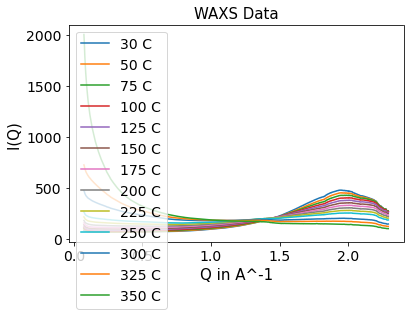

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1)

for x in range(len(H2O_runs)):
    axes.plot(data_holder[x][:,0], data_holder[x][:,1], label="{} C".format(H2O_temp[x]))
    
plt.xlabel("Q in A^-1", fontsize=15)
plt.ylabel("I(Q) ", fontsize=15)
#plt.xlim([expParams['Q'] * 0.5, expParams['Q'] * 1.5])
#plt.ylim([0,600])
plt.title("WAXS Data", fontsize=15)
plt.legend()
plt.show()

# Calculate the Differential Cross Section

In [33]:
my_density = 0.99 # g / ml

my_molecule = MoleculeZoo.molecule_zoo['H2O']
atten_length = IntensityEstimation.get_attenuation_length_cm(molecule_structure=my_molecule,
                                                             photon_energy_keV=15,
                                                             density=my_density)
atten_length *= 1e-2

In [34]:
photon_energy = 15.  # keV
I_in = 2.5  *1e12  # incoming xray flux [photons/sec] at 14keV
l    = 0.42         # sample-to-detector distance [m]
p    = 172. *1e-6  # detector pixel size [m]
d    = 2.   *1e-3  # sample thickness [m]

# solid angle covered by a single detector pixel
omega = (p / l)**2 

# Get effective sampe thickness
d_eff = atten_length * (1 - np.exp( - d / atten_length))

# Get the scatterred intensity at the specified Q value
q_idx = np.argmin(np.abs(data_holder[0][:,0] - expParams['Q'])) 
I_out = data_holder[0][q_idx, 1]

# Get the cross section
diff_cross = I_out / (omega * d_eff * I_in) #  30 C

print('The differential cross section at 350 C is {:.2f} [1/m]'.format(diff_cross))

The differential cross section at 350 C is 0.65 [1/m]


# Get the estimated scattering intensity at LCLS

In [35]:
incident_pulse_energy = 30.  # uJ
incident_pulse_energy_in_eV = incident_pulse_energy *  6241506479963.2

efficiency_per_branch = 0.008 # Transmission efficiency per branch of the split delay

photon_per_pulse = incident_pulse_energy_in_eV * efficiency_per_branch / (expParams['photon_energy_keV'] * 1000)   # photon number per branch per 
print("For each incident pulse, there are {:.2e} photons in each branch".format(photon_per_pulse))

For each incident pulse, there are 1.58e+08 photons in each branch


In [36]:
# Get the new attenuation
atten_length = IntensityEstimation.get_attenuation_length_cm(molecule_structure=my_molecule,
                                                             photon_energy_keV=expParams["photon_energy_keV"],
                                                             density=my_density)
atten_length *= 1e-2

inty_map = np.zeros((num, num)) #scattering intensity map

for idx1 in range(num):    
    for idx2 in range(num):
        
        #estimated scattering intensity on a single detector pixel [photons/pixels/shot]
        inty_map[idx1, idx2] = IntensityEstimation.get_scatter_intensity_with_differetial_crosssection(
            diff_cross_list = diff_cross,
            atten_length = atten_length,
            sample_thickness = thickness_list[idx1] * 1e-6,
            pixel_size = expParams['pixel_size'] * 1e-6,
            detector_distance = distance_list[idx2],
            incident_photon_count = photon_per_pulse)

print('done')

done


# Visualization

In [37]:
beta_map_2 = np.copy(beta_map)
beta_map_2[beta_map_2<0.01] = 0.

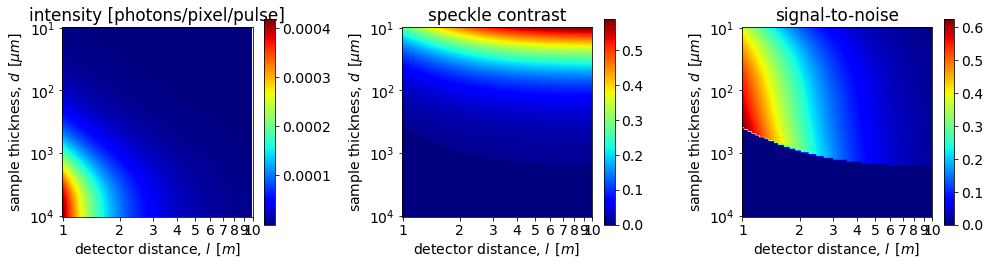

In [38]:
fig,ax = plt.subplots(1,3)
fig.set_figheight(3.8)
fig.set_figwidth(14.)

im = ax[0].imshow(inty_map, cmap='jet')
ax[0].set_xlabel('detector distance, '+r'$l \:\: [m]$')
ax[0].set_ylabel('sample thickness, '+r'$d \:\: [\mu m]$')
ax[0].set_title('intensity [photons/pixel/pulse]')

ax[0].set_xticks([100 * np.log10(x + 1) for x in range(10)])
ax[0].set_xticklabels(["{}".format(x + 1) for x in range(10)])
ax[0].set_yticks([33 * x for x in range(4)])
ax[0].set_yticklabels(["$10^{}$".format(x + 1) for x in range(5)])

fig.colorbar(im,ax=ax[0])


#speckle contrast
im = ax[1].imshow(beta_map_2,cmap='jet')
ax[1].set_xlabel('detector distance, '+r'$l \:\: [m]$')
ax[1].set_ylabel('sample thickness, '+r'$d \:\: [\mu m]$')
ax[1].set_title('speckle contrast')

ax[1].set_xticks([100 * np.log10(x + 1) for x in range(10)])
ax[1].set_xticklabels(["{}".format(x + 1) for x in range(10)])
ax[1].set_yticks([33 * x for x in range(4)])
ax[1].set_yticklabels(["$10^{}$".format(x + 1) for x in range(5)])

fig.colorbar(im,ax=ax[1])


#signal-to-noise ratio
N_shots = 2. * 120. * 3600.     # number of shots per condition
#snr_map = inty_map * beta_map_2 * np.sqrt(N_shots) * np.sqrt(pixel_num_holder[np.newaxis, :])/(2*(1+beta_map_2))
snr_map = inty_map * beta_map_2 * np.sqrt(N_shots) * 1500 /(2*(1+beta_map_2))

im = ax[2].imshow(snr_map,cmap='jet')
ax[2].set_xlabel('detector distance, '+r'$l \:\: [m]$')
ax[2].set_ylabel('sample thickness, '+r'$d \:\: [\mu m]$')
ax[2].set_title('signal-to-noise')

ax[2].set_xticks([100 * np.log10(x + 1) for x in range(10)])
ax[2].set_xticklabels(["{}".format(x + 1) for x in range(10)])
ax[2].set_yticks([33 * x for x in range(4)])
ax[2].set_yticklabels(["$10^{}$".format(x + 1) for x in range(5)])

fig.colorbar(im,ax=ax[2])


plt.tight_layout()
plt.show()

In [53]:
det_idx = np.argmin(np.abs(distance_list - 1.0))

# Intensity_holder
intensity_holder = inty_map[:, det_idx]
contrast_holder = beta_map[:, det_idx]

# Get three specific thickness
thickness_list2 = np.array([50, 100, 200, 350]) * 1e-6
SNR_vs_time_cruve = []

measure_time = np.logspace(0, 6, 100) / 3600.

for x in range(4):
    thickness_idx = np.argmin(np.abs(thickness_list * 1e-6 - thickness_list2[x]))
    print("contrast is {:.2f}".format(beta_map[thickness_idx, det_idx]))
    SNR_at_1e6 = snr_map[thickness_idx, det_idx]
    SNR_vs_time_cruve.append(SNR_at_1e6 / np.sqrt(N_shots) * np.sqrt(measure_time * 3600 * 120))

thickness_idx = np.argmin(np.abs(thickness_list * 1e-6 - 350e-6))
print("photon/pixel/pulse {:.2e}".format(inty_map[thickness_idx, det_idx]))
#print("photon number {:.2e}".format(pixel_num_holder[det_idx]))
print("photon number {:.2e}".format(1500 ** 2))
print("contrast {:.2e}".format(beta_map[thickness_idx, det_idx]))
print("SNR {:.2e}".format(snr_map[thickness_idx, det_idx]))

contrast is 0.06
contrast is 0.03
contrast is 0.02
contrast is 0.01
photon/pixel/pulse 8.15e-05
photon number 2.25e+06
contrast 1.10e-02
SNR 6.21e-01


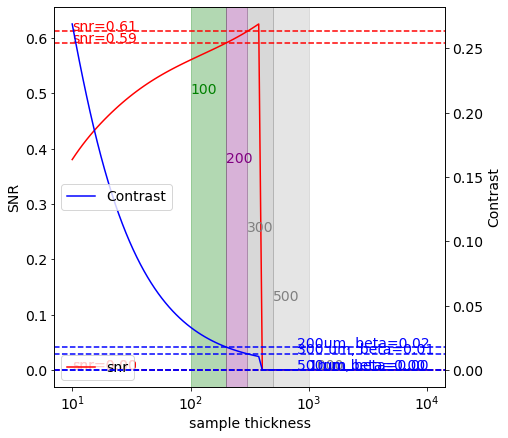

In [54]:
fig, ax = plt.subplots(1,1)
fig.set_figwidth(7)
fig.set_figheight(7)

ax.semilogx(thickness_list, snr_map[:, det_idx],c='red',label='snr')
ax.set_xlabel("sample thickness")
ax.set_ylabel("SNR")

axtwin = ax.twinx()
axtwin.semilogx(thickness_list, beta_map_2[:, det_idx], c='blue', label='Contrast')
axtwin.set_ylabel("Contrast")

axtwin.legend(loc='center left')
ax.legend(loc='lower left')

ax.axvspan(100, 200, alpha=0.3, color='green')
ax.axvspan(200, 300, alpha=0.3, color='purple')
ax.axvspan(300, 500, alpha=0.3, color='grey')
ax.axvspan(500, 1000, alpha=0.2, color='grey')

uplim = np.max(beta_map_2[:, det_idx])
axtwin.text(100, uplim * 0.8, '100', color='green')
axtwin.text(200, uplim * 0.6, '200', color='purple')
axtwin.text(300, uplim * 0.4, '300', color='grey')
axtwin.text(500, uplim * 0.2, '500', color='grey')
axtwin.text(1000, uplim * 0.0, '1000', color='grey')


thickness_idx = np.argmin(np.abs(thickness_list * 1e-6 - 200e-6))
axtwin.axhline(y=beta_map_2[thickness_idx, det_idx], color='blue', linestyle='--')
axtwin.text(800, beta_map_2[thickness_idx, det_idx] , 
            '200um, beta={:.2f}'.format(beta_map_2[thickness_idx, det_idx]), 
            color='blue')

ax.axhline(y=snr_map[thickness_idx, det_idx], color='red', linestyle='--')
ax.text(10, snr_map[thickness_idx, det_idx] , 
            'snr={:.2f}'.format(snr_map[thickness_idx, det_idx]), 
            color='red')

thickness_idx = np.argmin(np.abs(thickness_list * 1e-6 - 300e-6))
axtwin.axhline(y=beta_map_2[thickness_idx, det_idx], color='blue', linestyle='--')
axtwin.text(800, beta_map_2[thickness_idx, det_idx], 
            '300 um, beta={:.2f}'.format(beta_map_2[thickness_idx, det_idx]), 
            color='blue')

ax.axhline(y=snr_map[thickness_idx, det_idx], color='red', linestyle='--')
ax.text(10, snr_map[thickness_idx, det_idx], 
            'snr={:.2f}'.format(snr_map[thickness_idx, det_idx]), 
            color='red')

thickness_idx = np.argmin(np.abs(thickness_list * 1e-6 - 500e-6))
axtwin.axhline(y=beta_map_2[thickness_idx, det_idx], color='blue', linestyle='--')
axtwin.text(800, beta_map_2[thickness_idx, det_idx], 
            '500um beta={:.2f}'.format(beta_map_2[thickness_idx, det_idx]), 
            color='blue')

ax.axhline(y=snr_map[thickness_idx, det_idx], color='red', linestyle='--')
ax.text(10, snr_map[thickness_idx, det_idx], 
            'snr={:.2f}'.format(snr_map[thickness_idx, det_idx]), 
            color='red')

thickness_idx = np.argmin(np.abs(thickness_list * 1e-6 - 1000e-6))
axtwin.axhline(y=beta_map_2[thickness_idx, det_idx], color='blue', linestyle='--')
axtwin.text(1000, beta_map_2[thickness_idx, det_idx], 
            '1mm, beta={:.2f}'.format(beta_map_2[thickness_idx, det_idx]), 
            color='blue')

ax.axhline(y=snr_map[thickness_idx, det_idx], color='red', linestyle='--')
ax.text(10, snr_map[thickness_idx, det_idx], 
            'snr={:.2f}'.format(snr_map[thickness_idx, det_idx]), 
            color='red')

plt.show()

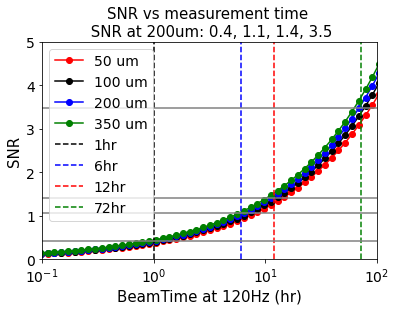

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=1)

colors = ['r','k','b','g']
for x in range(4):
    axes.semilogx(measure_time, SNR_vs_time_cruve[x], '-o', label="{:.0f} um".format(thickness_list2[x] * 1e6), c=colors[x])

axes.plot(np.ones(2), np.array([0, 100]), "--k", label='1hr')
axes.plot(np.ones(2) * 6, np.array([0, 100]), "--b", label='6hr')
axes.plot(np.ones(2) * 12, np.array([0, 100]), "--r", label='12hr')
axes.plot(np.ones(2) * 72, np.array([0, 100]), "--g", label='72hr')

snr_at_times = []
for x in [1, 6, 12, 72]:
    time_idx = np.argmin(np.abs(measure_time - x))
    snr_at_times.append(SNR_vs_time_cruve[2][time_idx])
    
axes.plot(np.array([0,100]), np.ones(2) * snr_at_times[0], "grey")
axes.plot(np.array([0,100]), np.ones(2) * snr_at_times[1], "grey")
axes.plot(np.array([0,100]), np.ones(2) * snr_at_times[2], "grey")
axes.plot(np.array([0,100]), np.ones(2) * snr_at_times[3], "grey")


plt.xlabel("BeamTime at 120Hz (hr)", fontsize=15)
plt.ylabel("SNR", fontsize=15)
plt.title("SNR vs measurement time \n "
          "SNR at 200um: {:.1f}, {:.1f}, {:.1f}, {:.1f}".format(snr_at_times[0],
                                                                snr_at_times[1],
                                                                snr_at_times[2],
                                                                snr_at_times[3],
                                                               ), fontsize=15)
plt.ylim([0, 5])
plt.xlim([0.1, 100])
plt.legend(loc='upper left')
plt.show()